2025/12/11
By Li.Jiahao
After learning the Deutsch Algorithm, we might think that quantum algorithm just saves the half query times which looks doesn't like a outstanding skill.So this section will reveal a new stuation that applies to multiple input bits.

# 1. Deutsch-Jozsa Algorithm



These problems involve functions of the form  $f:\Sigma^n \to \Sigma$, $n\ge 2$. For instance,let's consider determining the proporties(balanced or constant) of a function with a 3-bit input. we want to determine the type of a 3-bit input function. As mentioned in the previous article, characterize the function fully on a classical computer requires checking all $2^3 =8$ bits. However, the Deutsch-Jozsa Algorithm is far more efficient. Next, I will explain the details next.

## 1.1 Analysis
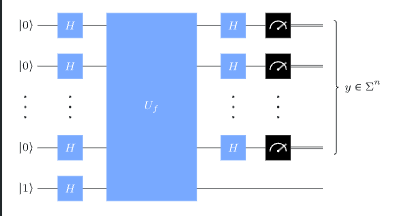

If we apply a H-gate to an arbitrary qubit, we can get:
$$
H|0\rangle = \frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle \\

H|1\rangle = \frac{1}{\sqrt{2}}|0\rangle - \frac{1}{\sqrt{2}}|1\rangle.$$
So, we use a parameter 'a' replacing the arbitrary state, and get:
$$
H|a\rangle = \frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}(-1)^a|1\rangle = \frac{1}{\sqrt{2}} \sum_{b \in \{0,1\}} (-1)^{ab}|b\rangle, $$

For a composite system consisting by several qubits and H-gates(just like the quantum circuit above), we can express it as follow:
$$
\begin{align*}
H^{\otimes n}|x_{n-1}\dots x_1x_0\rangle
&= (H|x_{n-1}\rangle) \otimes \cdots \otimes (H|x_0\rangle) \\
&= \left(\frac{1}{\sqrt{2}} \sum_{y_{n-1} \in \Sigma} (-1)^{x_{n-1}y_{n-1}}|y_{n-1}\rangle\right) \otimes \cdots \otimes \left(\frac{1}{\sqrt{2}} \sum_{y_0 \in \Sigma} (-1)^{x_0y_0}|y_0\rangle\right) \\
&= \frac{1}{\sqrt{2^n}} \sum_{y_{n-1}\dots y_0 \in \Sigma^n} (-1)^{x_{n-1}y_{n-1}+\cdots+x_0y_0}|y_{n-1}\dots y_0\rangle.
\end{align*}
$$
Then, we take the auxiliary qubit which in the state $|1\rangle$, the n+1 qubits can be represented as :
$$(|H|1\rangle)(H^{\otimes n}|0\dots 0\rangle) = |-\rangle \otimes \frac{1}{\sqrt{2^n}} \sum_{x_{n-1}\dots x_0 \in \Sigma^n} |x_{n-1}\dots x_0\rangle.$$

Now, we apply the $U_f$ gate, system evolves into :
$$|-\rangle \otimes \frac{1}{\sqrt{2^n}} \sum_{x_{n-1}\cdots x_0 \in \Sigma^n} (-1)^{f(x_{n-1}\cdots x_0)}|x_{n-1}\cdots x_0\rangle$$

Finally, we apply H-gates to all of the input qubits:
$$|-\rangle \otimes \frac{1}{2^n} \sum_{x_{n-1}\cdots x_0 \in \Sigma^n} \sum_{y_{n-1}\cdots y_0 \in \Sigma^n} (-1)^{f(x_{n-1}\cdots x_0)+x_{n-1}y_{n-1}+\cdots+x_0y_0} |y_{n-1}\cdots y_0\rangle.$$

This equation looks very complex.Fortunately, we only need to know the probability of measurement outcome $|0000\cdots 0\rangle$:
$$
\left| \frac{1}{2^n} \sum_{x_{n-1}\cdots x_0 \in \Sigma^n} (-1)^{f(x_{n-1}\cdots x_0)} \right|^2 = \begin{cases} 1 & \text{if } f \text{ is constant} \\ 0 & \text{if } f \text{ is balanced} \end{cases}
$$ 
Explanation: 
* 1.This part $x_{n-1}y_{n-1}+\cdots+x_0y_0$ disappears because of the orthogonality.
* 2.If function is constant, whatever inputs are, $f(x_0,x_1\cdots,x_{n-1})$ always equals to 0 or 1, the probabilities add up to 1 or -1.
* 3.If function is balanced, the outcome of $f(x_0,x_1\cdots,x_{n-1})$ are half 0 and half 1, the probabilities add up to 0.

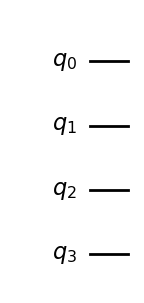

In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np

def dj_query(num_qubits):
    # Create a circuit implementing for a query gate for a random function
    # satisfying the promise for the Deutsch-Jozsa problem.
 
    qc = QuantumCircuit(num_qubits + 1)
 
    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc
 
    # Choose half the possible input strings
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )
 
    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc
 
    for state in on_states:
        qc.barrier()  # Barriers are added to help visualize how the functions are created.
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")
 
    qc.barrier()
 
    return qc

display(dj_query(3).draw(output="mpl"))

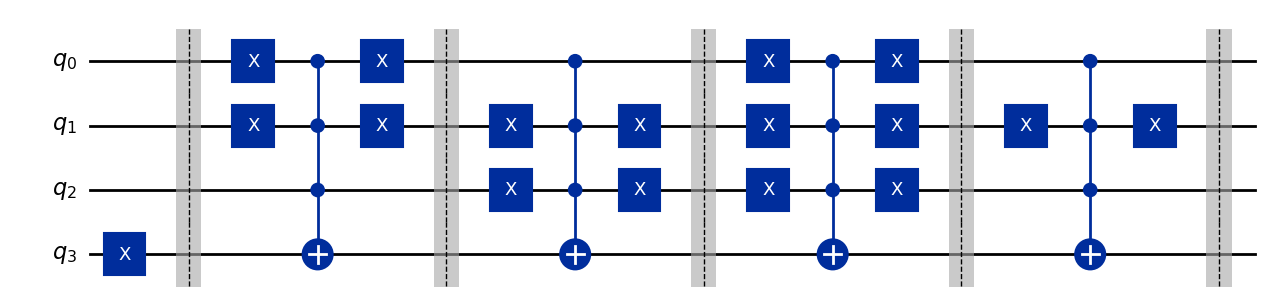

'balanced'

In [2]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in the Deutsch-Jozsa algorithm.
 
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

def dj_algorithm(function: QuantumCircuit):
    # Determine if a function is constant or balanced.
 
    qc = compile_circuit(function)
 
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if "1" in measurements[0]:
        return "balanced"
    return "constant"

f = dj_query(3)
display(f.draw("mpl"))
display(dj_algorithm(f))